In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from astropy.stats import binom_conf_interval
import pandas as pd

import sys
sys.path.append('./ncounts/')
from diagnostics_stripped import get_ratio_at_parameter, ncounts

In [2]:
#Load in total sample
merged = pd.read_csv('merged.csv', index_col=0)
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    #tmin = df['teff'] >= 3.6
    #tmax = df['teff'] <= 4.1
    #lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 5.0 #6.23 - 0.3*df['teff']
    
    return lmin # & lmax & tmin & tmax

in_box = merged[fyps_box(merged)]

# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = in_box[(in_box['n_peaks'] > 0) & (in_box['highest_amp']/in_box['highest_amp_error'] > 5)]
pulse_detected_all = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(len(pulse_detected),len(in_box))

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected,contaminants,left_index=True,right_index=True)
pulse_clean = new[(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]

new_all = pd.merge(pulse_detected_all,contaminants,left_index=True,right_index=True)
pulse_clean_all = new_all[(~new_all['LikelyRR'])&(~new_all['LikelyCep'])&(~new_all['LikelyBCep'])]
print(len(pulse_clean))

50 63
39


In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

data_all = merged[['teff','lum']].values
data_pulse = pulse_clean_all[['teff','lum']].values

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_all)
    
KDE_bandwidth = grid.best_estimator_.bandwidth
print(KDE_bandwidth)

kde_all = KernelDensity(bandwidth=KDE_bandwidth)
kde_all.fit(data_all)

kde_pulse = KernelDensity(bandwidth=KDE_bandwidth)
kde_pulse.fit(data_pulse)

X, Y = np.meshgrid(np.linspace(np.min(data_all[:,0]),np.max(data_all[:,0]),100), np.linspace(np.min(data_all[:,1]),np.max(data_all[:,1]),100))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_all = np.exp(kde_all.score_samples(xy)).reshape(X.shape)
Z_pulse = np.exp(kde_pulse.score_samples(xy)).reshape(X.shape)

0.09999999999999992


In [3]:
#confidence interval from Wilson (1927)

def return_conf(pulse,stars,kappa=1.0):
    """
    Returns mean and confidence interval
    
    Parameters
    ----------
    pulse : int
        Number of pulsators
    stars : int
        Number of total stars in sample
    kappa : int (default 1.0)
        Number of sigma to calculate
        
    Returns
    -------
    conf : array-like
        conf[0] is the mean, conf[1] is the symmetrical errorbar
    
    """
    assert kappa == 1.0, 'Only 1-sigma errors supported lmao'
    num = pulse + 0.5*kappa**2.0
    den = stars + kappa**2.0
    frac = num/den
    ci = binom_conf_interval(pulse,stars)
    return np.array([frac,frac-ci[0]])

In [4]:
all_conf = return_conf(len(pulse_clean),len(in_box))
print(f'Fraction of overall sample that are convincing: ${all_conf[0]:.3f} \pm {{{all_conf[1]:.3f}}}$')

lmc_conf = return_conf(len(pulse_clean[pulse_clean['Gal']=='LMC']),len(in_box[in_box['Gal']=='LMC']))
print(f'Fraction of LMC sample that are convincing:${lmc_conf[0]:.3f} \pm {{{lmc_conf[1]:.3f}}}$')

smc_conf = return_conf(len(pulse_clean[pulse_clean['Gal']=='SMC']),len(in_box[in_box['Gal']=='SMC']))
print(f'Fraction of SMC sample that are convincing: ${smc_conf[0]:.3f} \pm {{{smc_conf[1]:.3f}}}$')

Fraction of overall sample that are convincing: $0.617 \pm {0.061}$
Fraction of LMC sample that are convincing:$0.606 \pm {0.071}$
Fraction of SMC sample that are convincing: $0.639 \pm {0.113}$


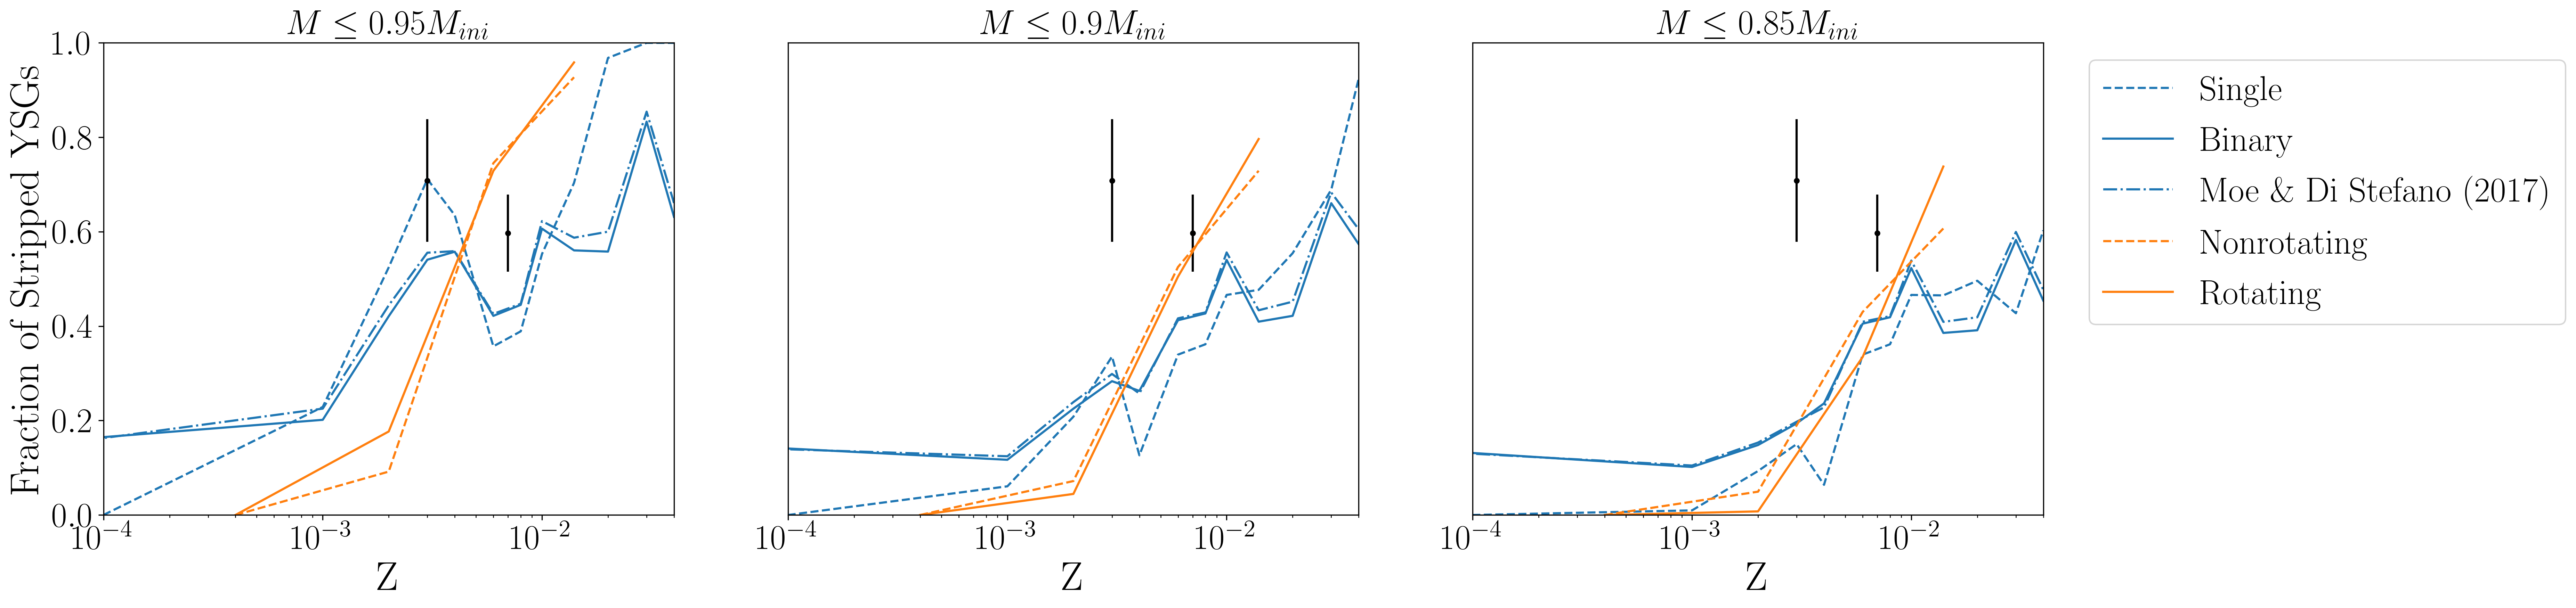

In [6]:
ls_dict = {0.0:'--',1.0:'-'}

fMs = [0.95,0.9,0.85]

fig,ax = plt.subplots(1,3,figsize=(24,6),dpi=300)

f_bins = [0.0,1.0]
bin_lab = ['Single','Binary']
f_rots = [0.0,1.0]
rot_lab = ['Nonrotating','Rotating']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
znames=['zem5','zem4','z001','z002','z003','z004','z006','z008','z010','z014','z020','z030','z040']
mets = [0.003,0.007]
for i,fM in enumerate(fMs):
    for f_bin,l in zip(f_bins,bin_lab):
        ax[i].semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=f_bin,SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames],c='C0',ls=ls_dict[f_bin],label=l)
    ax[i].semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames],c='C0',ls='-.',label='Moe \& Di Stefano (2017)')

z_float_g = [0.0004,0.002,0.006,0.014]
znames_g=['z0004','z002','z006','z014']
for i,fM in enumerate(fMs):
    for f_rot,l in zip(f_rots,rot_lab):
        ax[i].semilogx(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=f_rot,SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames_g],c='C1',ls=ls_dict[f_rot],label=l)


    ax[i].errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
    ax[i].errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)

for i,a in enumerate(ax):
    if i==2:
        a.legend(loc='upper left',fontsize=24,bbox_to_anchor=(1.05, 1))
    elif i == 0:
        a.set_ylabel('Fraction of Stripped YSGs')
    if i != 0:
        a.set_yticks([])
    a.set(ylim=(0,1),xlim=(1e-4,0.04),xlabel='Z')
    a.set_title(f'$M \leq {fMs[i]}M_{{ini}}$',fontsize=24)
    a.xaxis.label.set_size(28)
    a.yaxis.label.set_size(28)
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)

plt.savefig('../plots/stripped_fM.pdf')

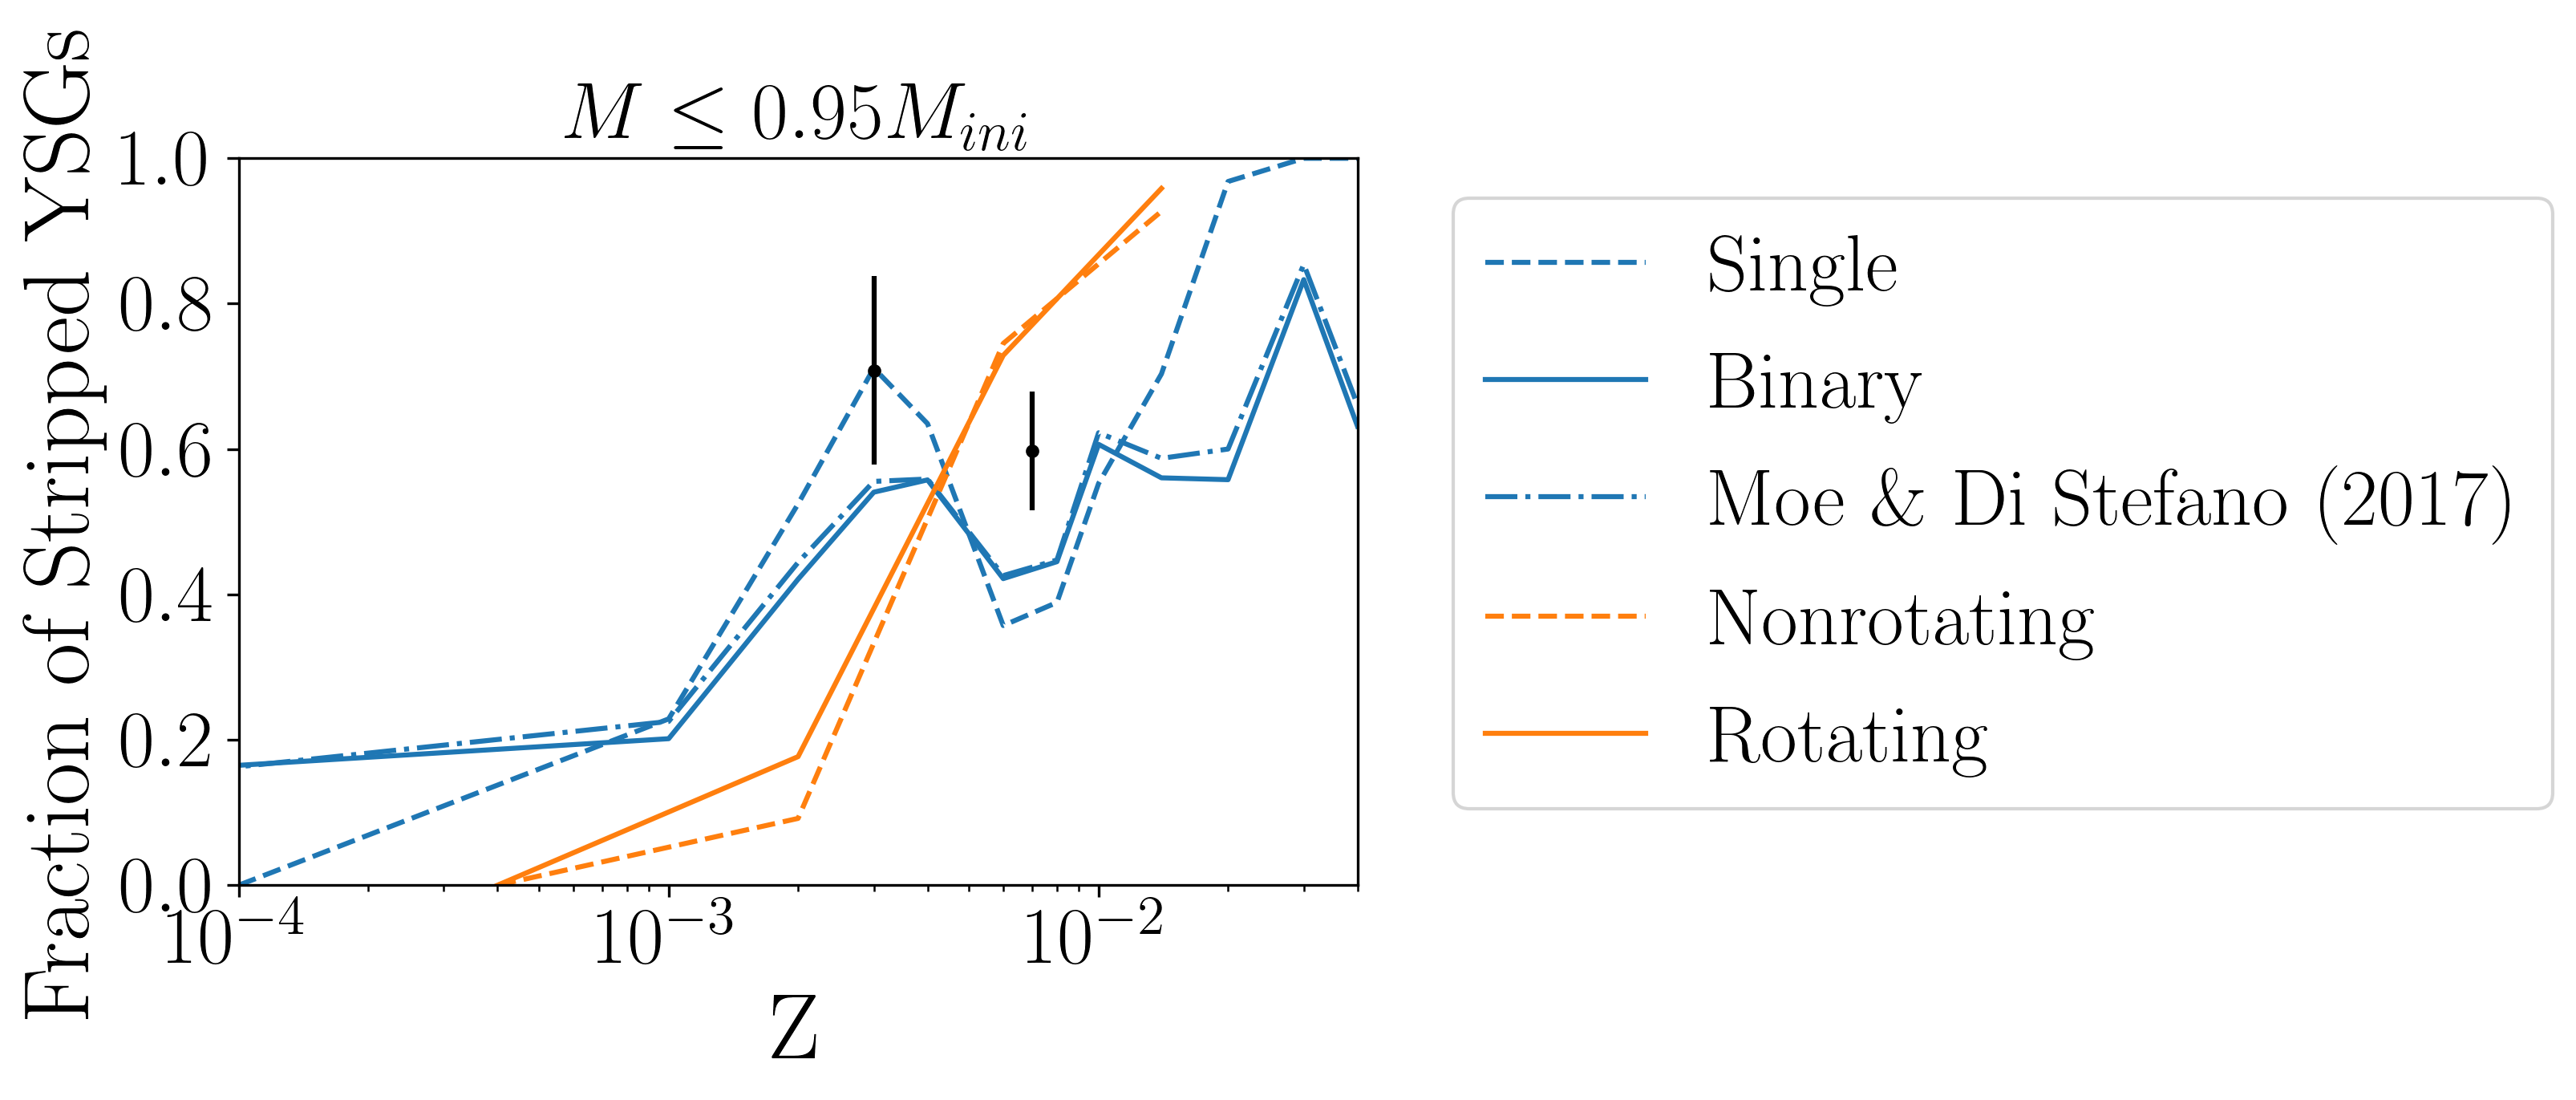

In [7]:
ls_dict = {0.0:'--',1.0:'-'}


fig = plt.figure(dpi=300)

f_bins = [0.0,1.0]
bin_lab = ['Single','Binary']
f_rots = [0.0,1.0]
rot_lab = ['Nonrotating','Rotating']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
znames=['zem5','zem4','z001','z002','z003','z004','z006','z008','z010','z014','z020','z030','z040']
mets = [0.003,0.007]

for f_bin,l in zip(f_bins,bin_lab):
    plt.semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=f_bin,SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames],c='C0',ls=ls_dict[f_bin],label=l)
plt.semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames],c='C0',ls='-.',label='Moe \& Di Stefano (2017)')

    
z_float_g = [0.0004,0.002,0.006,0.014]
znames_g=['z0004','z002','z006','z014']
for f_rot,l in zip(f_rots,rot_lab):
    plt.semilogx(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=f_rot,SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames_g],c='C1',ls=ls_dict[f_rot],label=l)


plt.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
plt.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)

a = plt.gca()
a.legend(fontsize=24,bbox_to_anchor=(1.05, 1))
a.set_ylabel('Fraction of Stripped YSGs')
a.set(ylim=(0,1),xlim=(1e-4,0.04),xlabel='Z')
a.set_title(f'$M \leq {0.95}M_{{ini}}$',fontsize=24)
a.xaxis.label.set_size(28)
a.yaxis.label.set_size(28)
for tick in a.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in a.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

plt.savefig('../plots/stripped.pdf',bbox_inches='tight')

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


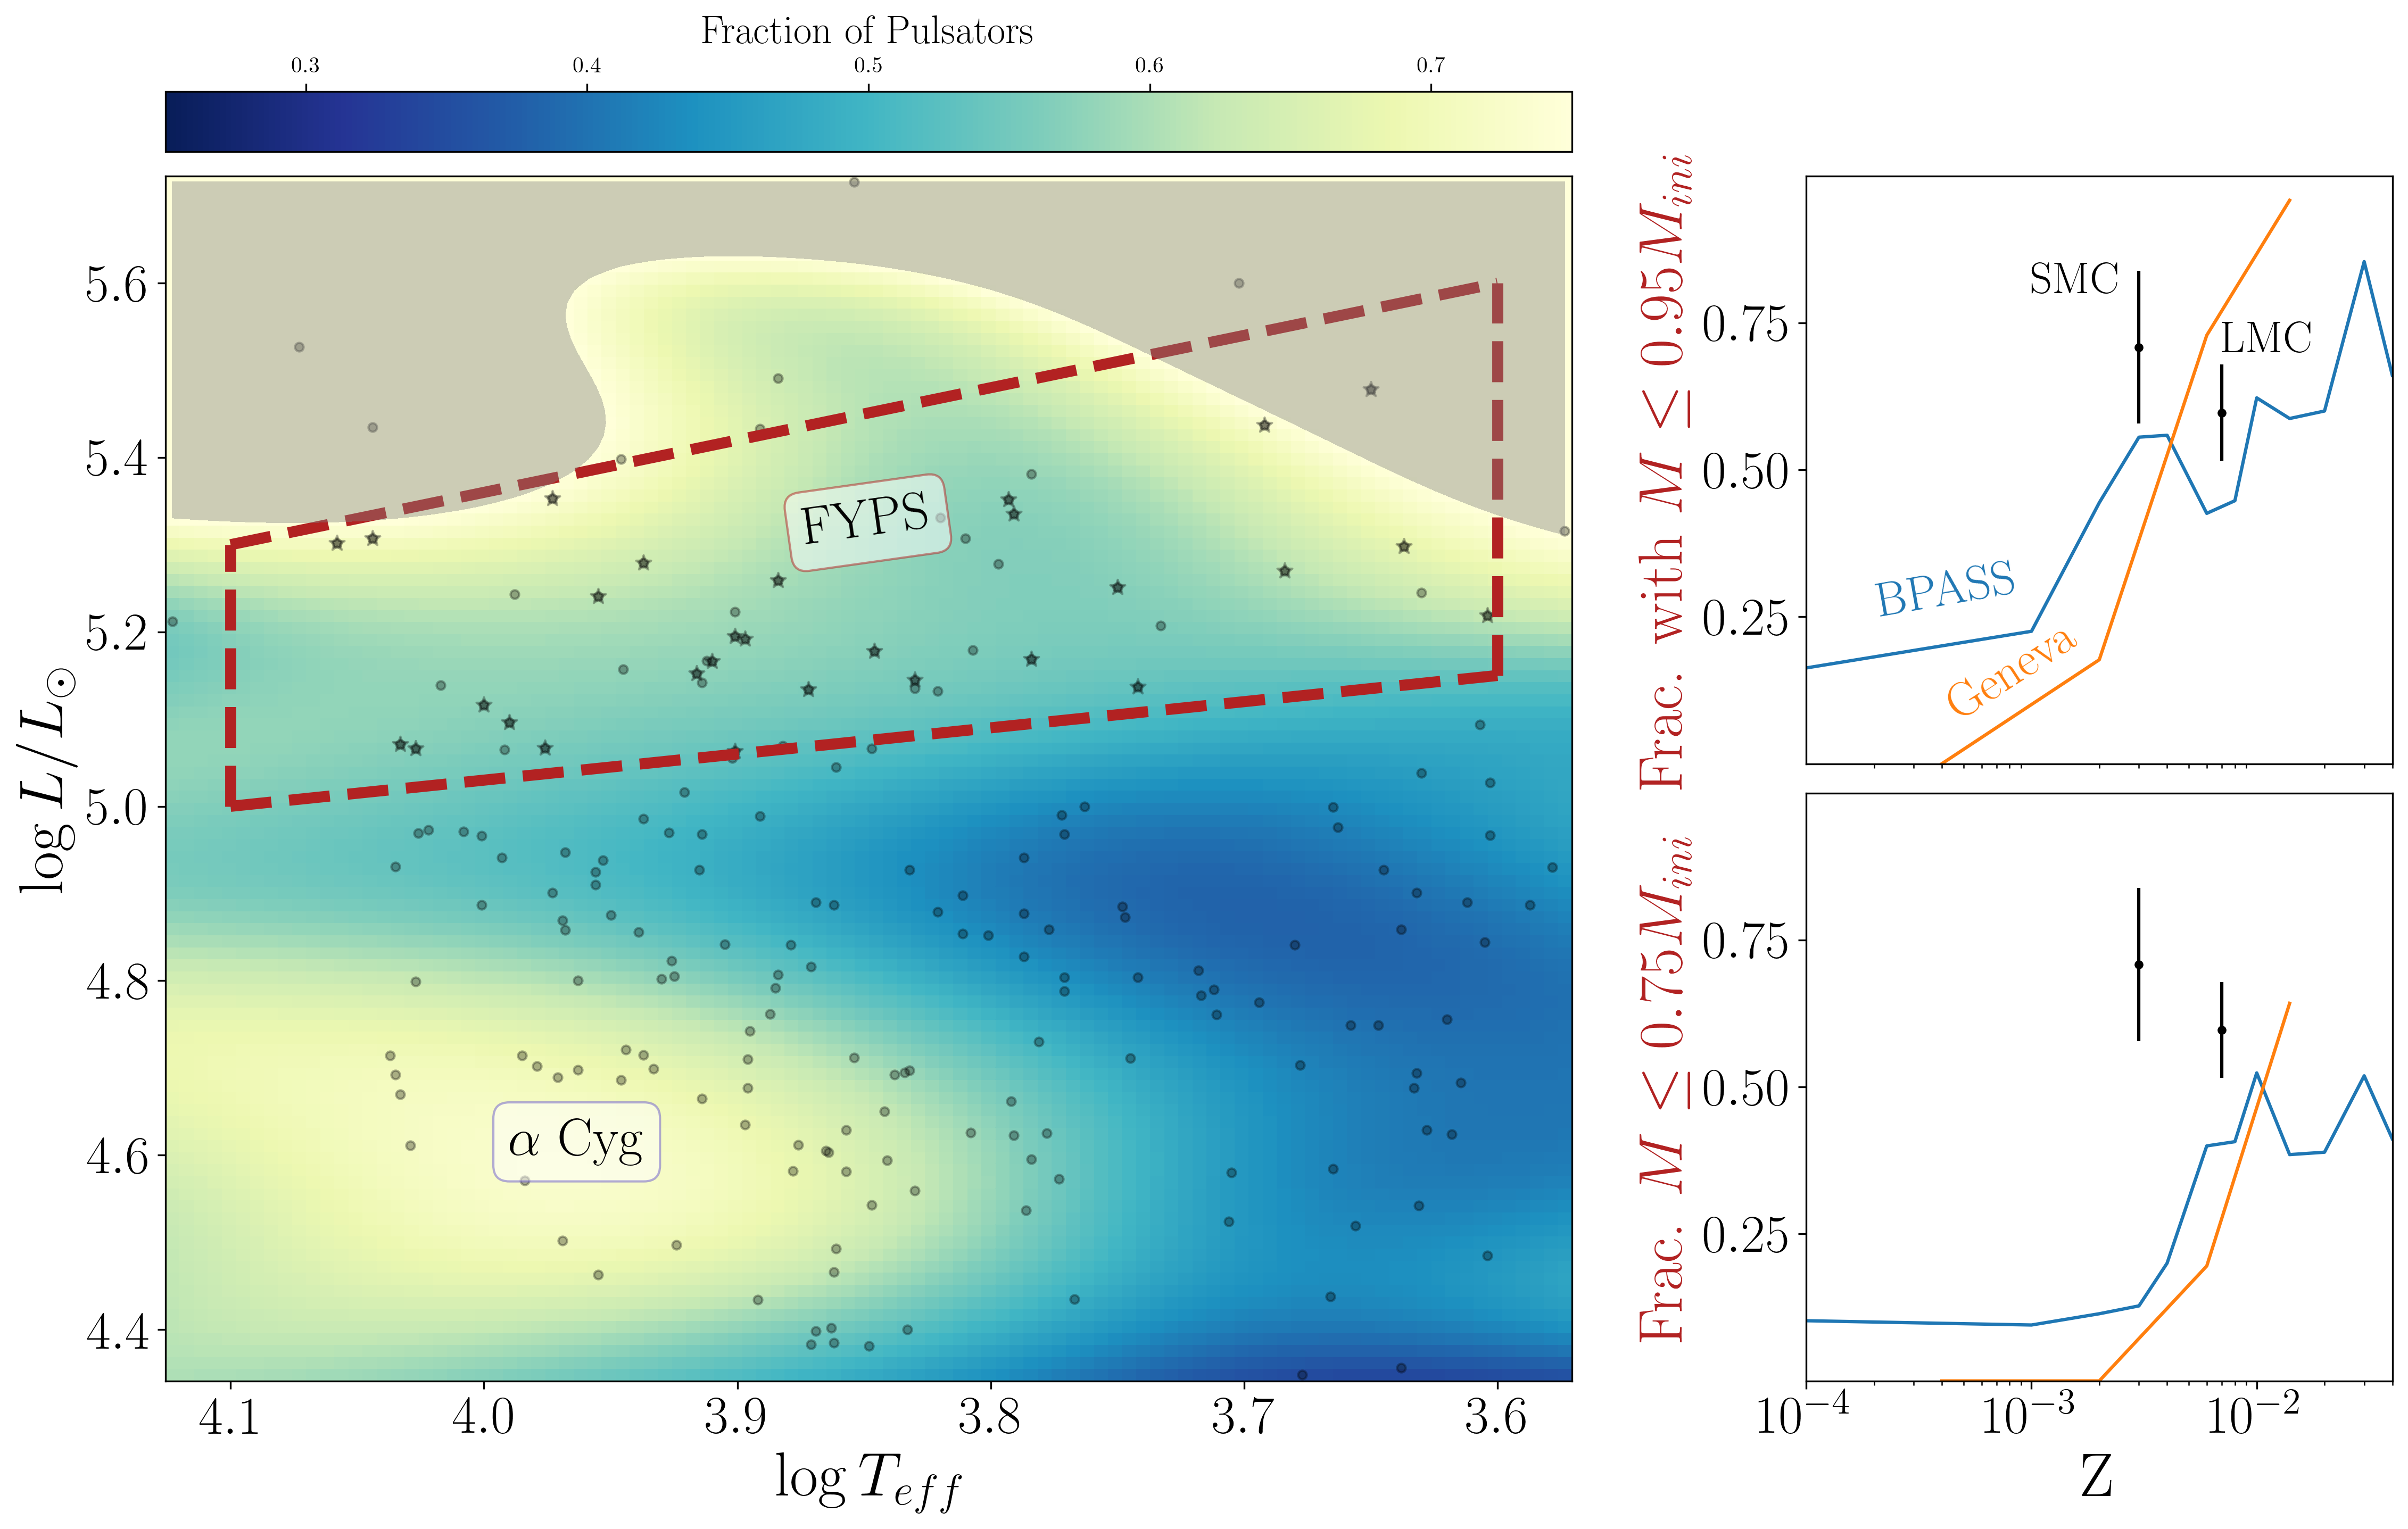

In [20]:
instability_strip = pd.read_table('paper_2020/instability_strip.txt',sep=' ',index_col=False)
fyps = pd.read_csv('paper_2020/fyps.csv')
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(dpi=300, constrained_layout=True,figsize=(18,10))
gs = gridspec.GridSpec(ncols=3, nrows=2, wspace=0.4, hspace=0.05)

ax1 = fig.add_subplot(gs[:,:2])

mp = ax1.pcolormesh(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')
#cb = ax1.colorbar(mp)
#cb.set_label(r'$f_{\rm pulse}$',fontsize=20)
#cb.set_ticks([0.25,0.5,0.75])

ax1.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5)
ax1.invert_xaxis()
xl = ax1.get_xlim()
yl = ax1.get_ylim()
axins = inset_axes(ax1,
                   width="100%",  # width = 100% of parent_bbox width
                   height="5%",  # height : 5%
                   loc='upper right',
                   bbox_to_anchor=(0., 0.07, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
from matplotlib import colors, cm
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=0.25,vmax=0.75)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='YlGnBu_r'),cax=axins,orientation='horizontal',pad=0.2)
axins.xaxis.set_ticks_position('top')
for tick in axins.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
axins.set_title('Fraction of Pulsators',fontsize=18)

ax1.scatter(merged['teff'],merged['lum'],c='k',alpha=0.3,s=15)
ax1.scatter(pulse_clean['teff'],pulse_clean['lum'],c='k',marker='*',alpha=0.3,s=50)

ax1.plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1)


ax1.text(3.875,5.3,'FYPS',c='k',fontdict={'fontsize':24},rotation=8,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))
ax1.text(3.99,4.6,r'$\alpha$ Cyg',c='k',fontdict={'fontsize':24},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='slateblue',
                   fc='w',
                   alpha=0.5))

ax1.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax1.xaxis.label.set_size(28)
ax1.yaxis.label.set_size(28)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
    
ax2 = fig.add_subplot(gs[0,2])

f_bins = [0.0,1.0]
bin_lab = ['Single','Binary']
f_rots = [0.0,1.0]
rot_lab = ['Nonrotating','Rotating']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
znames=['zem5','zem4','z001','z002','z003','z004','z006','z008','z010','z014','z020','z030','z040']
mets = [0.003,0.007]

ax2.semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames],c='C0',label='BPASS')
    
z_float_g = [0.0004,0.002,0.006,0.014]
znames_g=['z0004','z002','z006','z014']
ax2.semilogx(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=1.0,SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames_g],c='C1',label='Geneva')


ax2.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
ax2.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)
ax2.text(2e-4,0.25,'BPASS',fontdict={'fontsize':22},rotation=10,c='C0')
ax2.text(4e-4,0.075,'Geneva',fontdict={'fontsize':22},rotation=33,c='C1')
ax2.text(0.001,0.8,'SMC',fontdict={'fontsize':20})
ax2.text(0.007,0.7,'LMC',fontdict={'fontsize':20})

ax2.set_ylabel('Frac. with $M \leq 0.95M_{{ini}}$',color='firebrick')
ax2.set(ylim=(0,1),xlim=(1e-4,0.04),xticks=[],yticks=[0.25,0.5,0.75])
ax2.xaxis.label.set_size(28)
ax2.yaxis.label.set_size(28)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
    
ax3 = fig.add_subplot(gs[1,2])

ax3.loglog(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=0.75,fMcut2=1.0) for z in znames],c='C0',label='BPASS')

ax3.loglog(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=1.0,SFH='const',fMcut1=0.75,fMcut2=1.0) for z in znames_g],c='C1',label='Geneva')
ax3.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
ax3.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)
ax3.set_yscale('linear')

ax3.set(ylim=(0,1),xlim=(1e-4,0.04),xlabel='Z',yticks=[0.25,0.5,0.75])
ax3.set_ylabel('Frac. $M \leq 0.75M_{{ini}}$',color='firebrick')

ax3.xaxis.label.set_size(28)
ax3.yaxis.label.set_size(28)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
plt.savefig('../../Jobs/NSF_AAPF_2021/hr_frac.pdf',bbox_inches='tight')

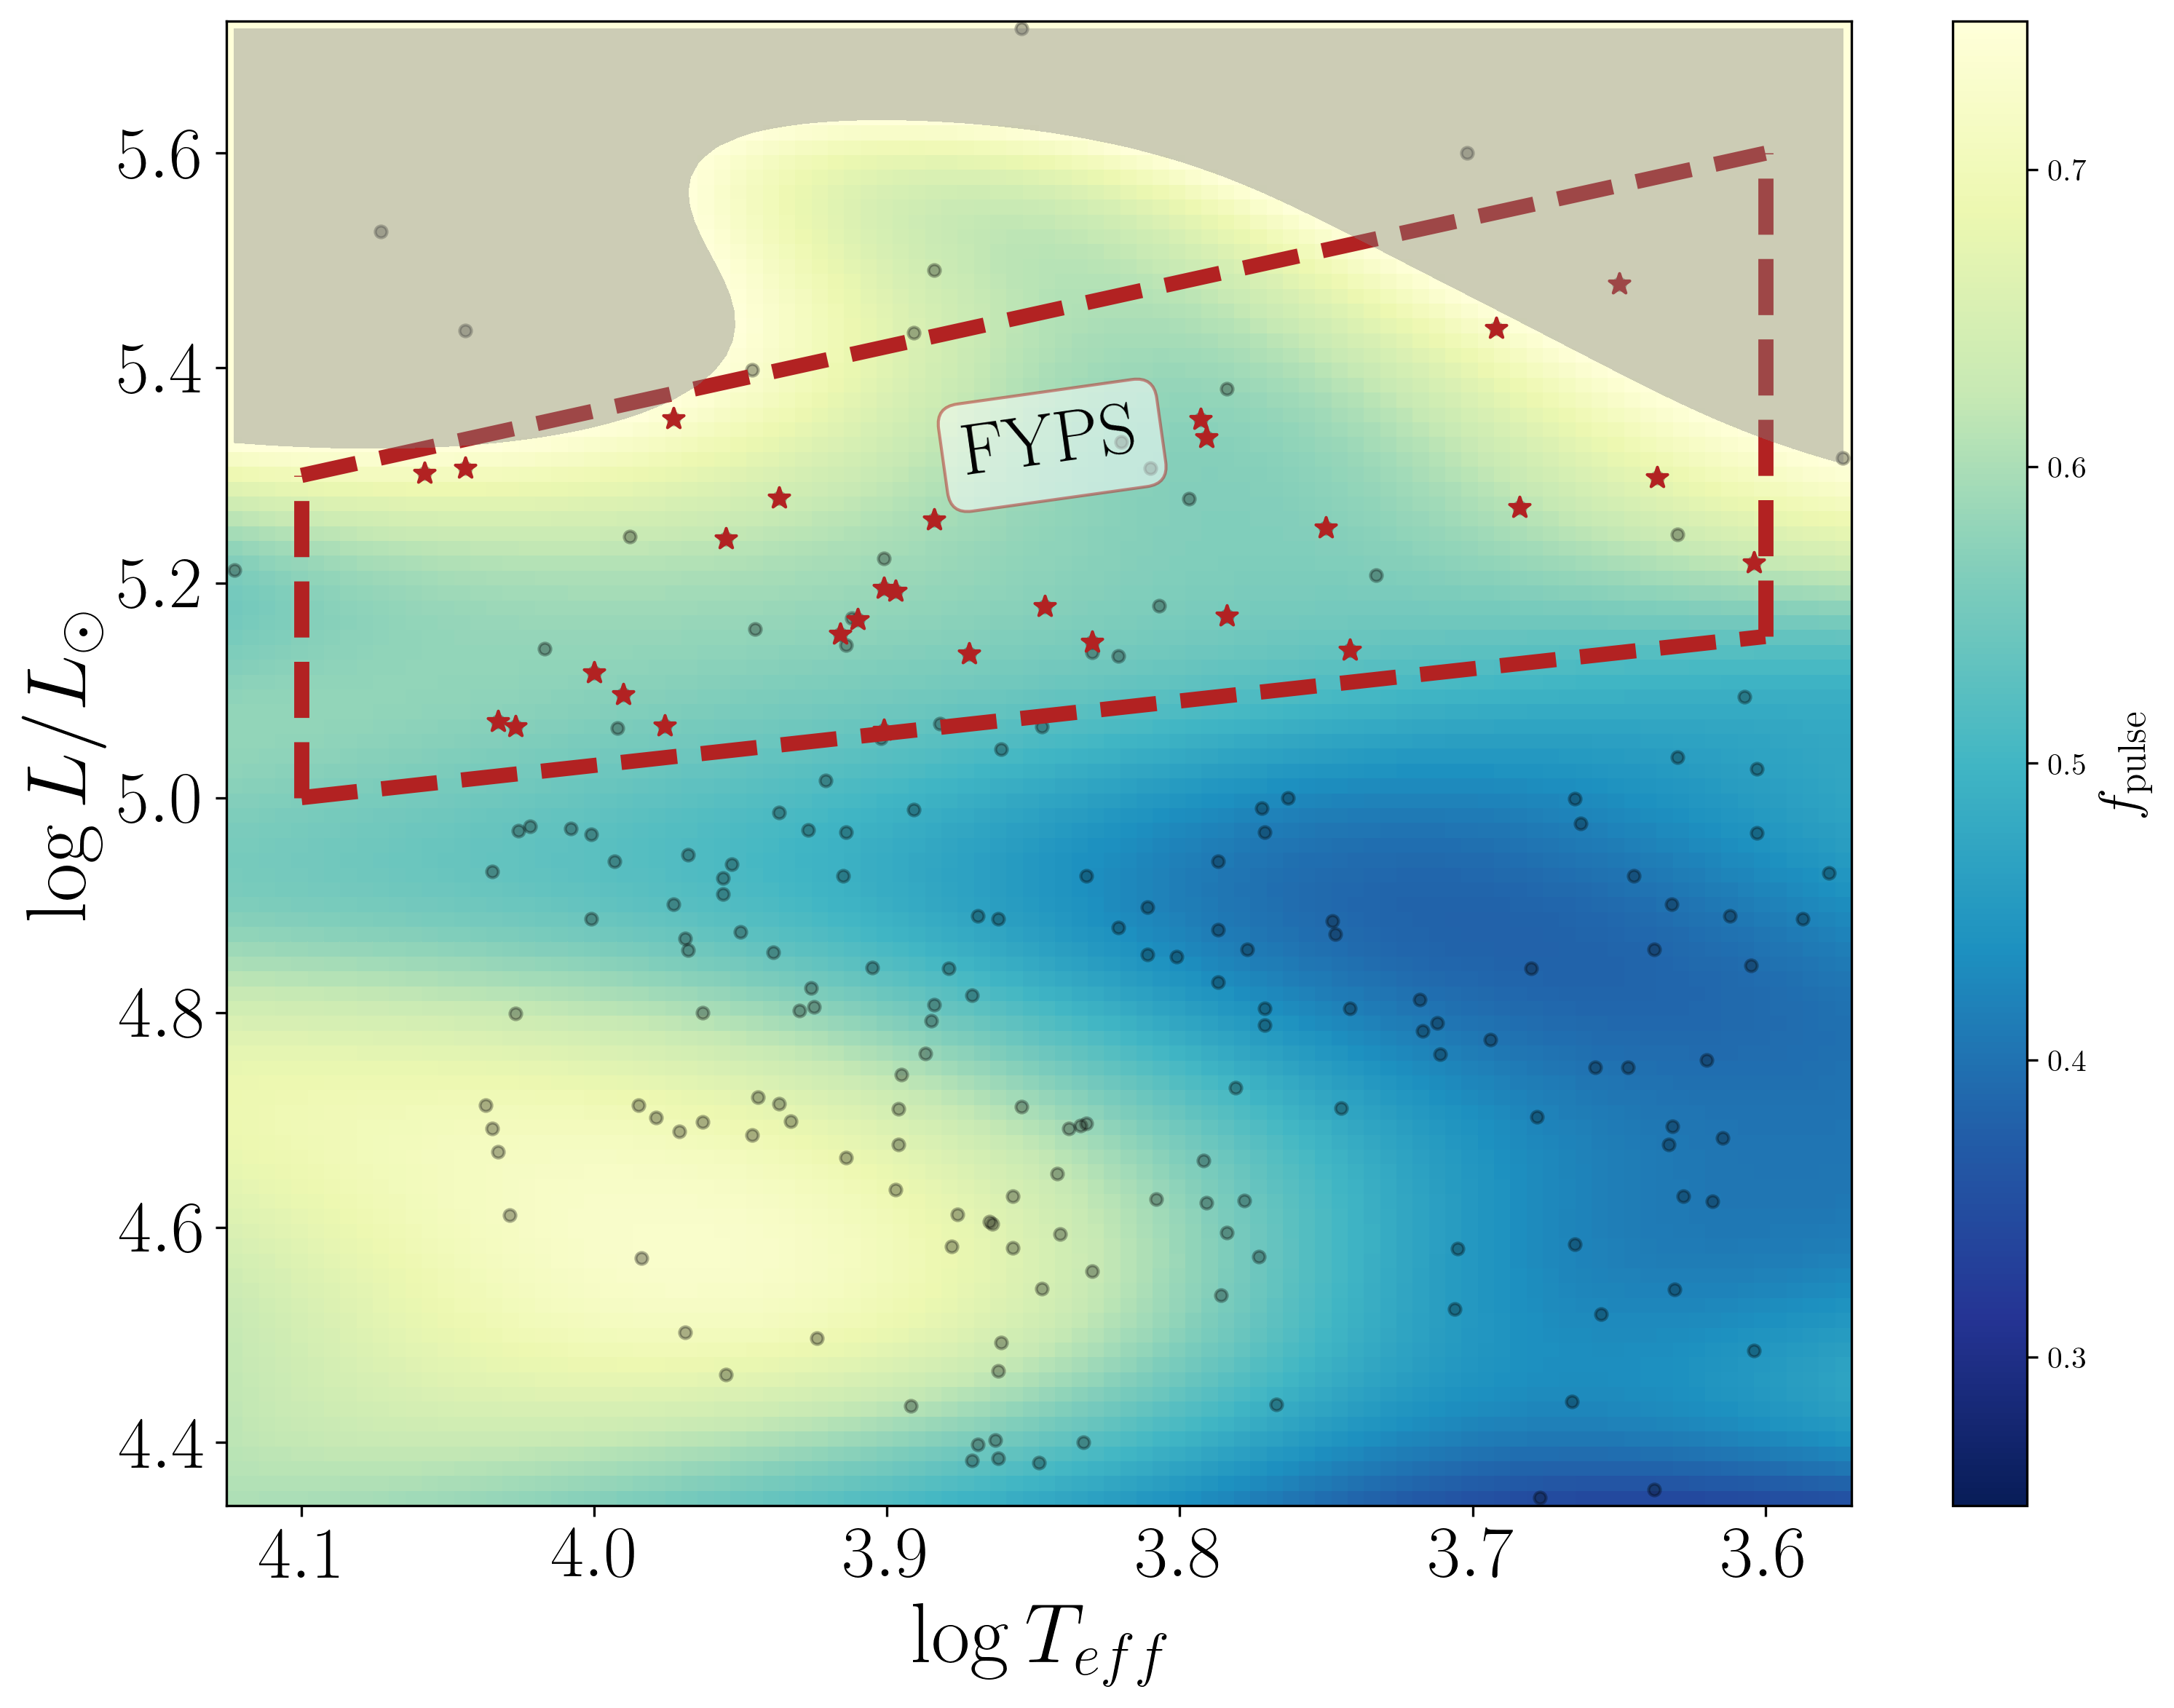

In [34]:
instability_strip = pd.read_table('paper_2020/instability_strip.txt',sep=' ',index_col=False)
fyps = pd.read_csv('paper_2020/fyps.csv')
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(dpi=300,figsize=(12,9))
ax1 = fig.add_subplot(111)
mp = ax1.pcolormesh(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')
#cb = ax1.colorbar(mp)
#cb.set_label(r'$f_{\rm pulse}$',fontsize=20)
#cb.set_ticks([0.25,0.5,0.75])

ax1.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5)
ax1.invert_xaxis()
xl = ax1.get_xlim()
yl = ax1.get_ylim()

from matplotlib import colors, cm
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=0.25,vmax=0.75)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='YlGnBu_r'))
for tick in axins.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
cbar.set_label(r'$f_{\rm pulse}$',fontsize=18)

ax1.scatter(merged['teff'],merged['lum'],c='k',alpha=0.3,s=15)
ax1.scatter(pulse_clean['teff'],pulse_clean['lum'],c='firebrick',marker='*',s=50)

ax1.plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1)


ax1.text(3.875,5.3,'FYPS',c='k',fontdict={'fontsize':24},rotation=8,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))
"""ax1.text(3.99,4.6,r'$\alpha$ Cyg',c='k',fontdict={'fontsize':24},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='slateblue',
                   fc='w',
                   alpha=0.5))"""

ax1.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax1.xaxis.label.set_size(28)
ax1.yaxis.label.set_size(28)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

    
plt.savefig('../../Jobs/NPP/hr_frac.pdf',bbox_inches='tight')

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


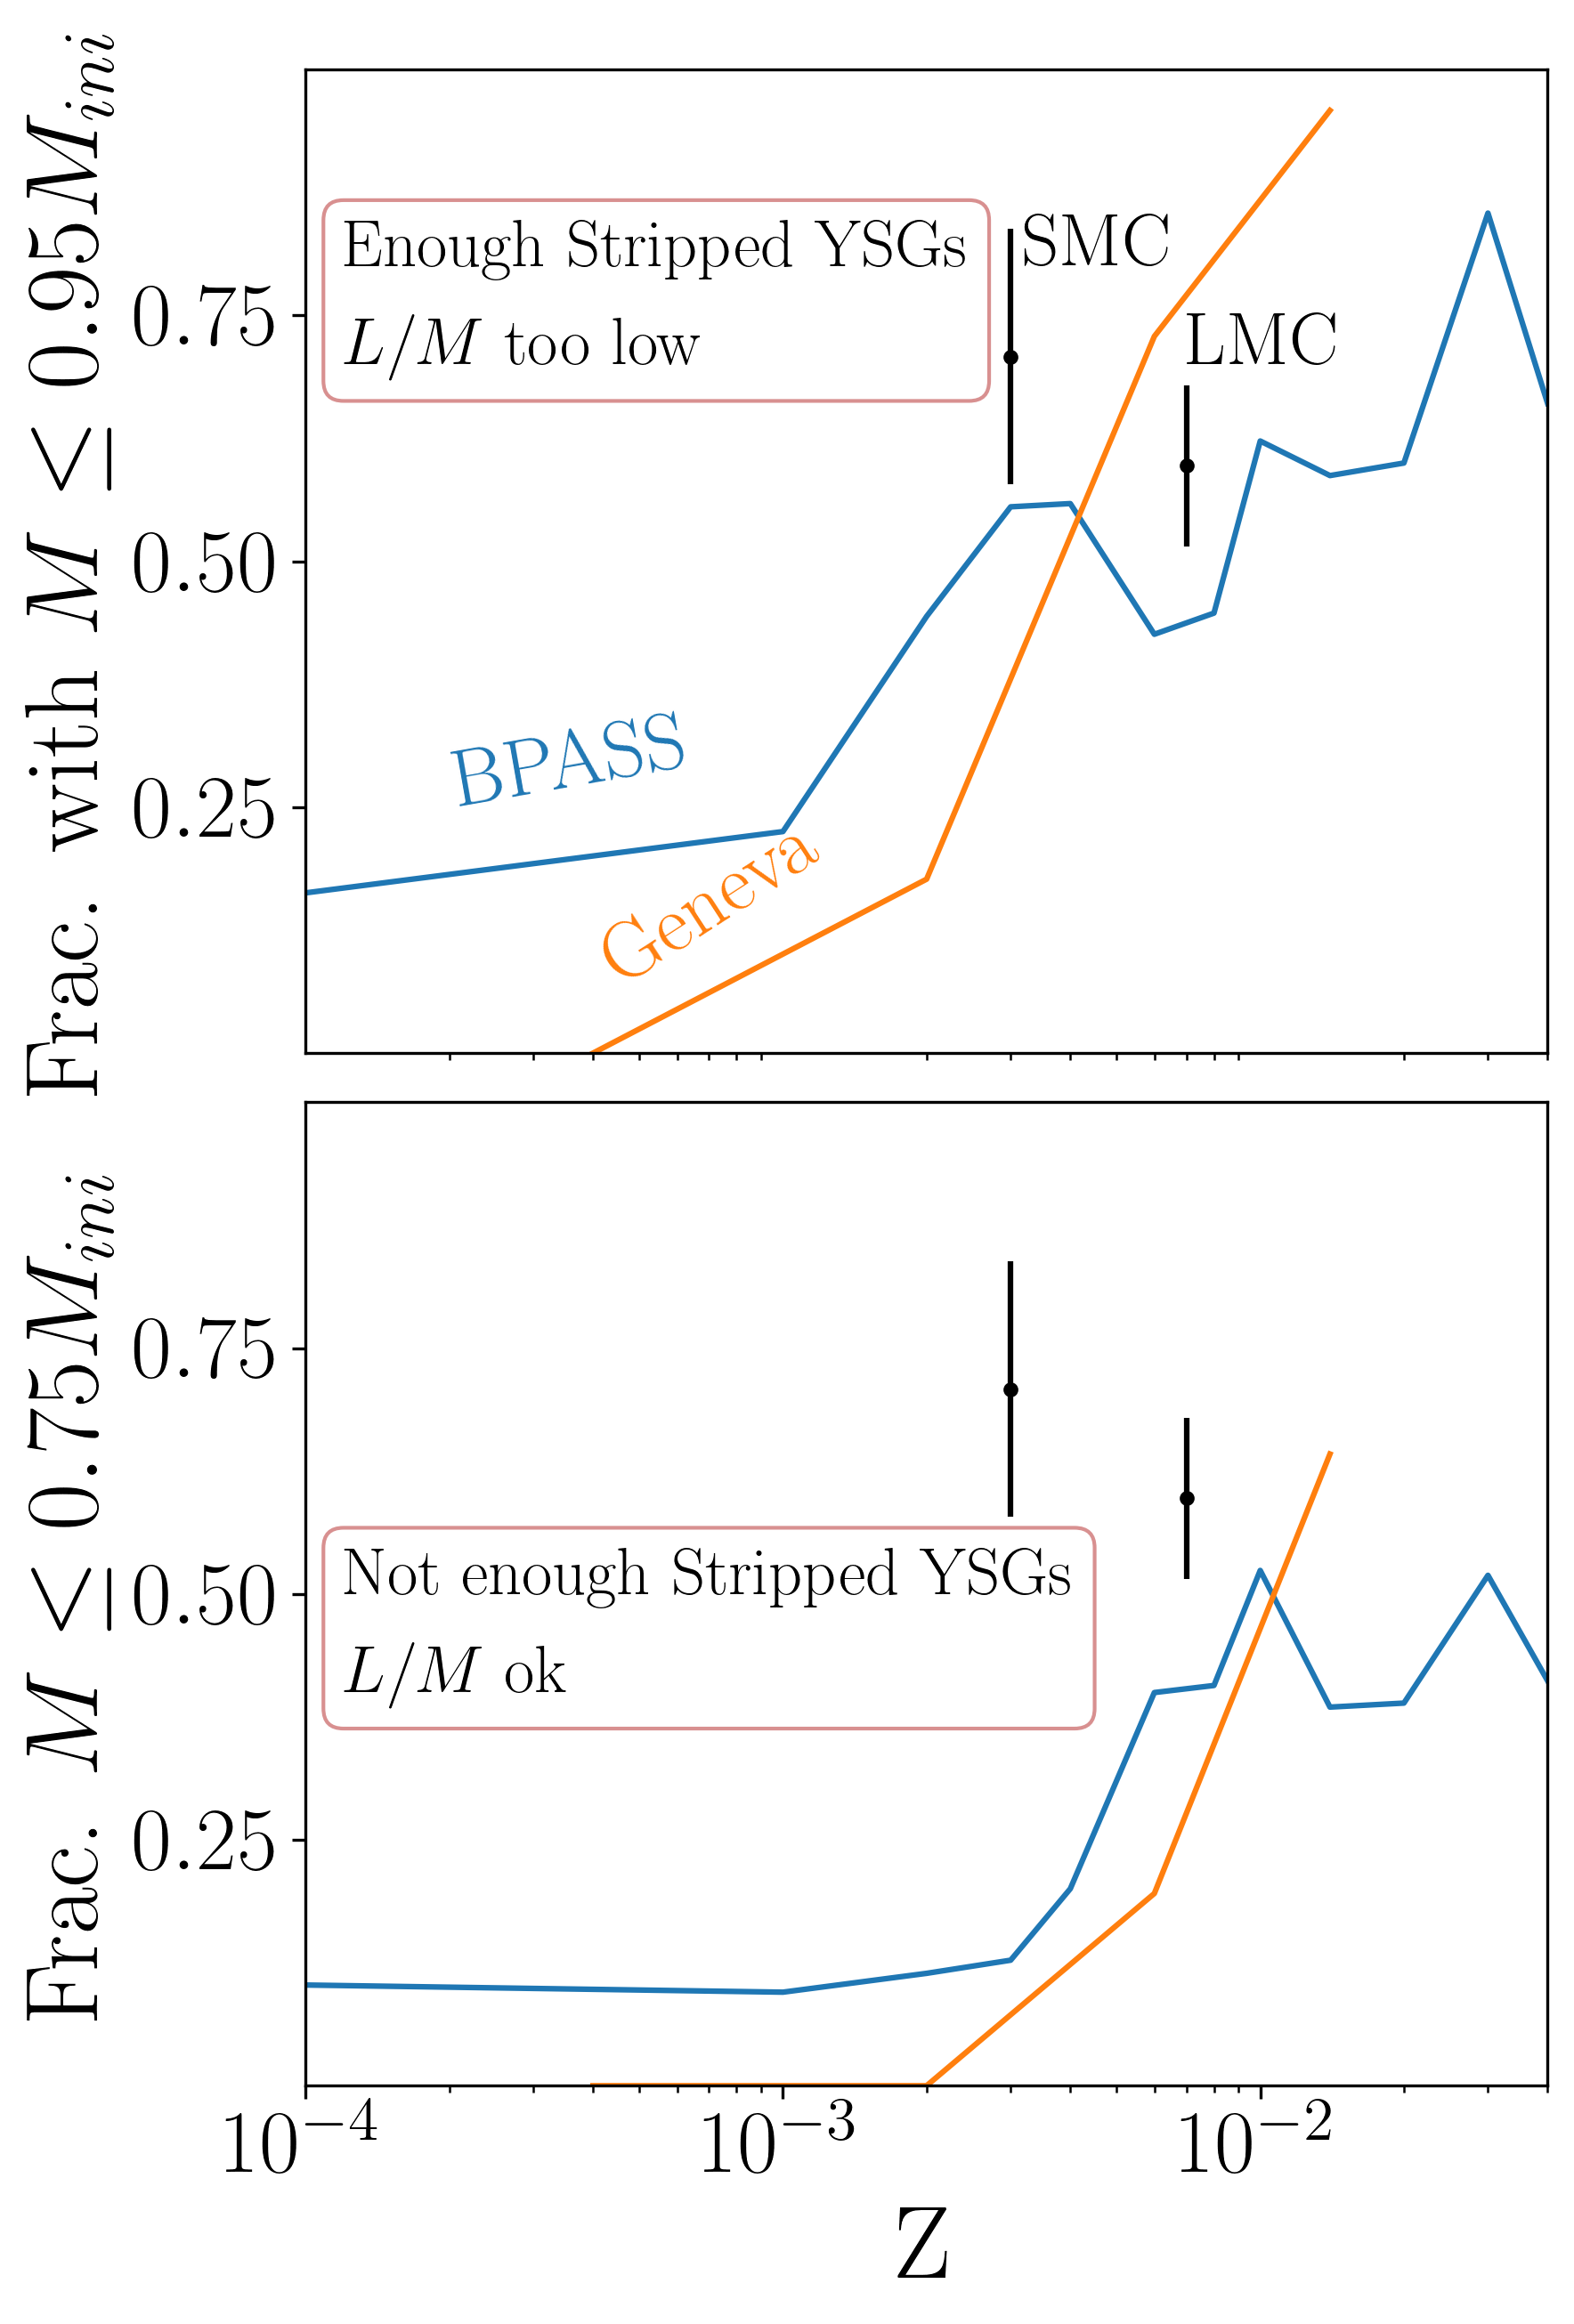

In [135]:
fig = plt.figure(dpi=300, constrained_layout=True,figsize=(6,10))
gs = gridspec.GridSpec(ncols=1, nrows=2, wspace=0.4, hspace=0.05)
    
ax2 = fig.add_subplot(gs[0,0])

f_bins = [0.0,1.0]
bin_lab = ['Single','Binary']
f_rots = [0.0,1.0]
rot_lab = ['Nonrotating','Rotating']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
znames=['zem5','zem4','z001','z002','z003','z004','z006','z008','z010','z014','z020','z030','z040']
mets = [0.003,0.007]

ax2.semilogx(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames],c='C0',label='BPASS')
    
z_float_g = [0.0004,0.002,0.006,0.014]
znames_g=['z0004','z002','z006','z014']
ax2.semilogx(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=1.0,SFH='const',fMcut1=0.95,fMcut2=1.0) for z in znames_g],c='C1',label='Geneva')


ax2.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
ax2.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)
ax2.text(2e-4,0.25,'BPASS',fontdict={'fontsize':22},rotation=10,c='C0')
ax2.text(4e-4,0.07,'Geneva',fontdict={'fontsize':22},rotation=33,c='C1')
ax2.text(0.0032,0.8,'SMC',fontdict={'fontsize':20})
ax2.text(0.007,0.7,'LMC',fontdict={'fontsize':20})
ax2.text(1.2e-4,0.8,r'\noindent Enough Stripped YSGs $\\\\$ $L/M$ too low',fontdict={'fontsize':18},
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))

ax2.set_ylabel('Frac. with $M \leq 0.95M_{{ini}}$')
ax2.set(ylim=(0,1),xlim=(1e-4,0.04),xticks=[],yticks=[0.25,0.5,0.75])
ax2.xaxis.label.set_size(28)
ax2.yaxis.label.set_size(28)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
    
ax3 = fig.add_subplot(gs[1,0])

ax3.loglog(z_float,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=0.75,fMcut2=1.0) for z in znames],c='C0',label='BPASS')

ax3.loglog(z_float_g,[get_ratio_at_parameter('In/In',z,np.log10(13.7e9),f_rot=1.0,SFH='const',fMcut1=0.75,fMcut2=1.0) for z in znames_g],c='C1',label='Geneva')
ax3.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
ax3.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)
ax3.set_yscale('linear')

ax3.text(1.2e-4,0.5,r'\noindent Not enough Stripped YSGs $\\\\$ $L/M$ ok',fontdict={'fontsize':18},
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))

ax3.set(ylim=(0,1),xlim=(1e-4,0.04),xlabel='Z',yticks=[0.25,0.5,0.75])
ax3.set_ylabel('Frac. $M \leq 0.75M_{{ini}}$')

ax3.xaxis.label.set_size(28)
ax3.yaxis.label.set_size(28)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
plt.savefig('../../Proposals/Flatiron/models.pdf',bbox_inches='tight')

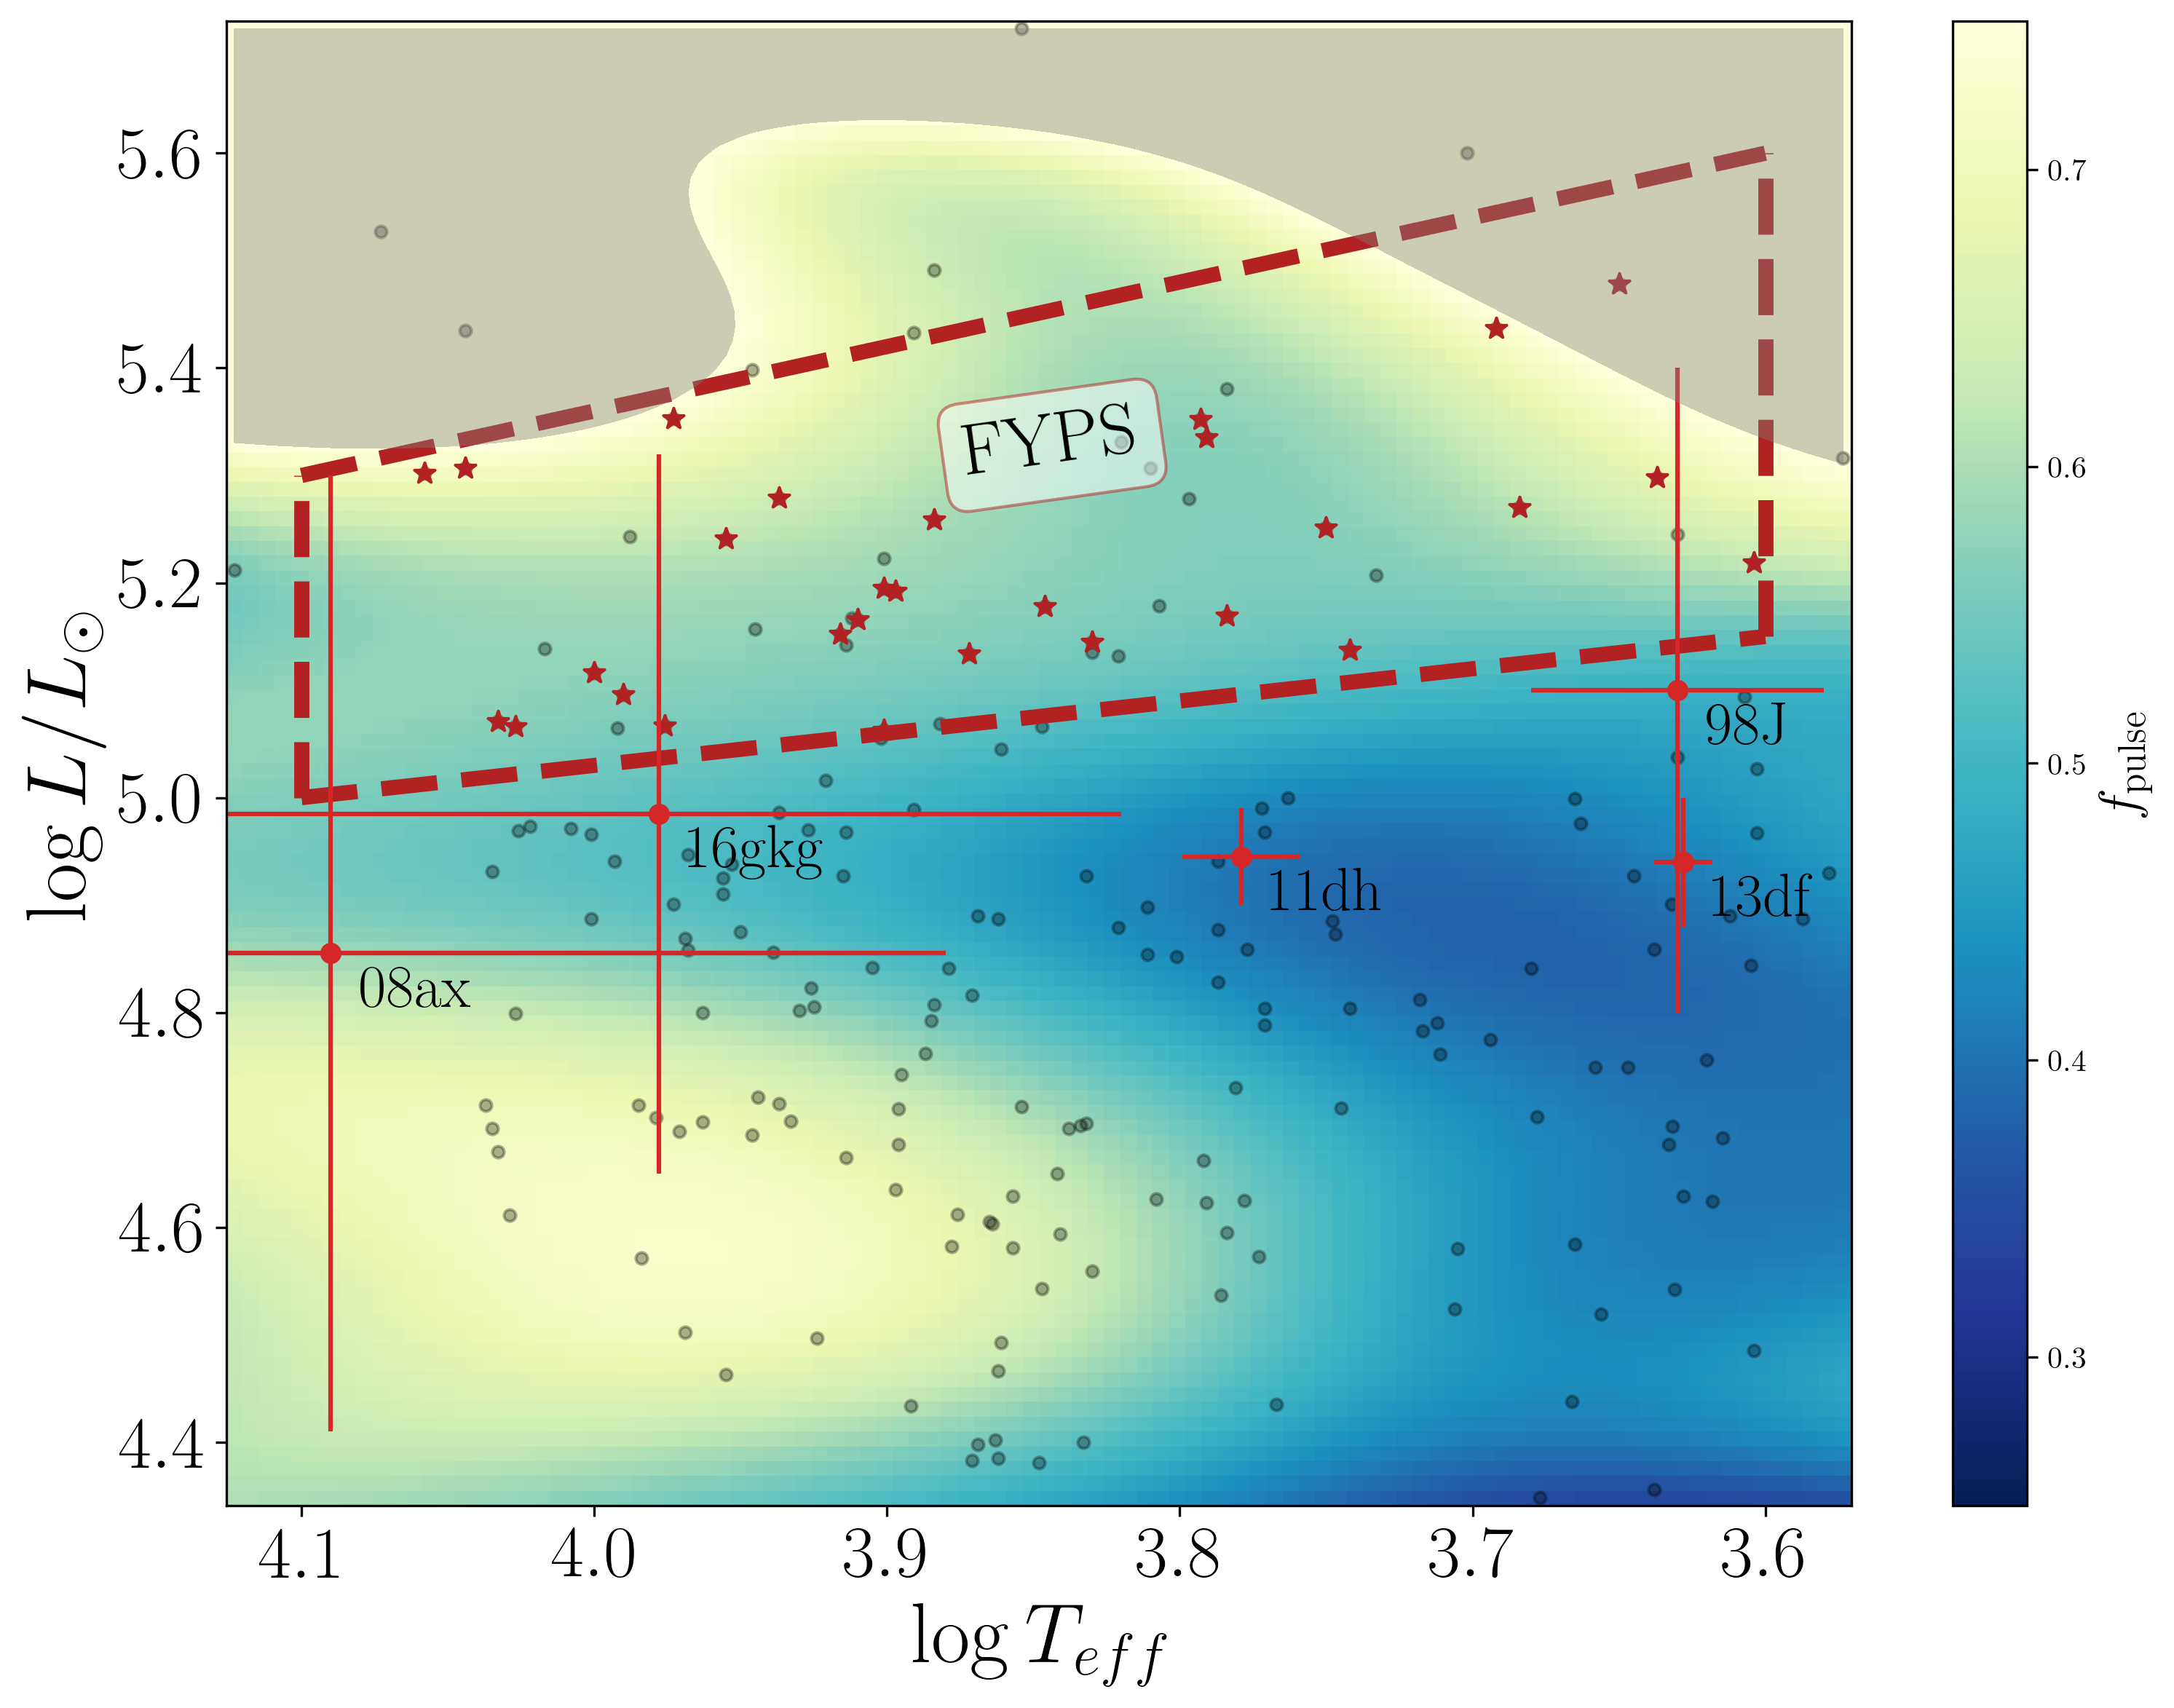

In [58]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(dpi=300,figsize=(12,9))
ax1 = fig.add_subplot(111)
mp = ax1.pcolormesh(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')
#cb = ax1.colorbar(mp)
#cb.set_label(r'$f_{\rm pulse}$',fontsize=20)
#cb.set_ticks([0.25,0.5,0.75])

ax1.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean_all)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5)
ax1.invert_xaxis()
xl = ax1.get_xlim()
yl = ax1.get_ylim()

from matplotlib import colors, cm
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=0.25,vmax=0.75)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='YlGnBu_r'))
for tick in axins.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
cbar.set_label(r'$f_{\rm pulse}$',fontsize=18)

ax1.scatter(merged['teff'],merged['lum'],c='k',alpha=0.3,s=15)
ax1.scatter(pulse_clean['teff'],pulse_clean['lum'],c='firebrick',marker='*',s=50)

ax1.plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1)
ax1.plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1)


ax1.text(3.875,5.3,'FYPS',c='k',fontdict={'fontsize':24},rotation=8,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))

ax1.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)





#Let's add on some SN IIb progenitors! Info from Yoon+17
SN_Teff = np.array([3.63, #1993J, Aldering+94, Maund+04
                    4.09, #2008ax, Folatelli+15
                    3.779, #2011dh, Maund+11, Van Dyk+11, Bersten+12
                    3.628, #2013df, Van Dyk+14
                    3.978 #2016gkg, Kilpatrick+16, Tartaglia+16
                    ])
SN_Teff_err = np.array([[0.05,0.05],
                        [0.21,0.21],
                        [0.02,0.02],
                        [0.01,0.01],
                        [0.158,0.215]
                       ]).T
SN_L = np.array([5.1,
                 4.855,
                 4.945,
                 4.94,
                 4.985
                ])
SN_Lerr = np.array([0.3,
                    0.445,
                    0.045,
                    0.06,
                    0.335])

SN_names = ['98J','08ax','11dh','13df','16gkg']

plt.errorbar(SN_Teff,SN_L,xerr=SN_Teff_err,yerr=SN_Lerr,fmt='o',c='C3')

for n,t,l in zip(SN_names,SN_Teff,SN_L):
    plt.text(t-0.01,l-0.05,n,fontsize=20)


ax1.xaxis.label.set_size(28)
ax1.yaxis.label.set_size(28)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

    

In [50]:
4.985-4.65

0.33499999999999996

In [37]:
plt.errorbar()

0.20999999999999996

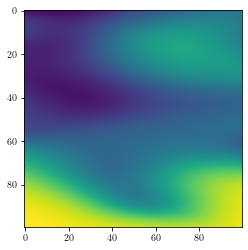

In [31]:
plt.imshow(Z_pulse/Z_all)

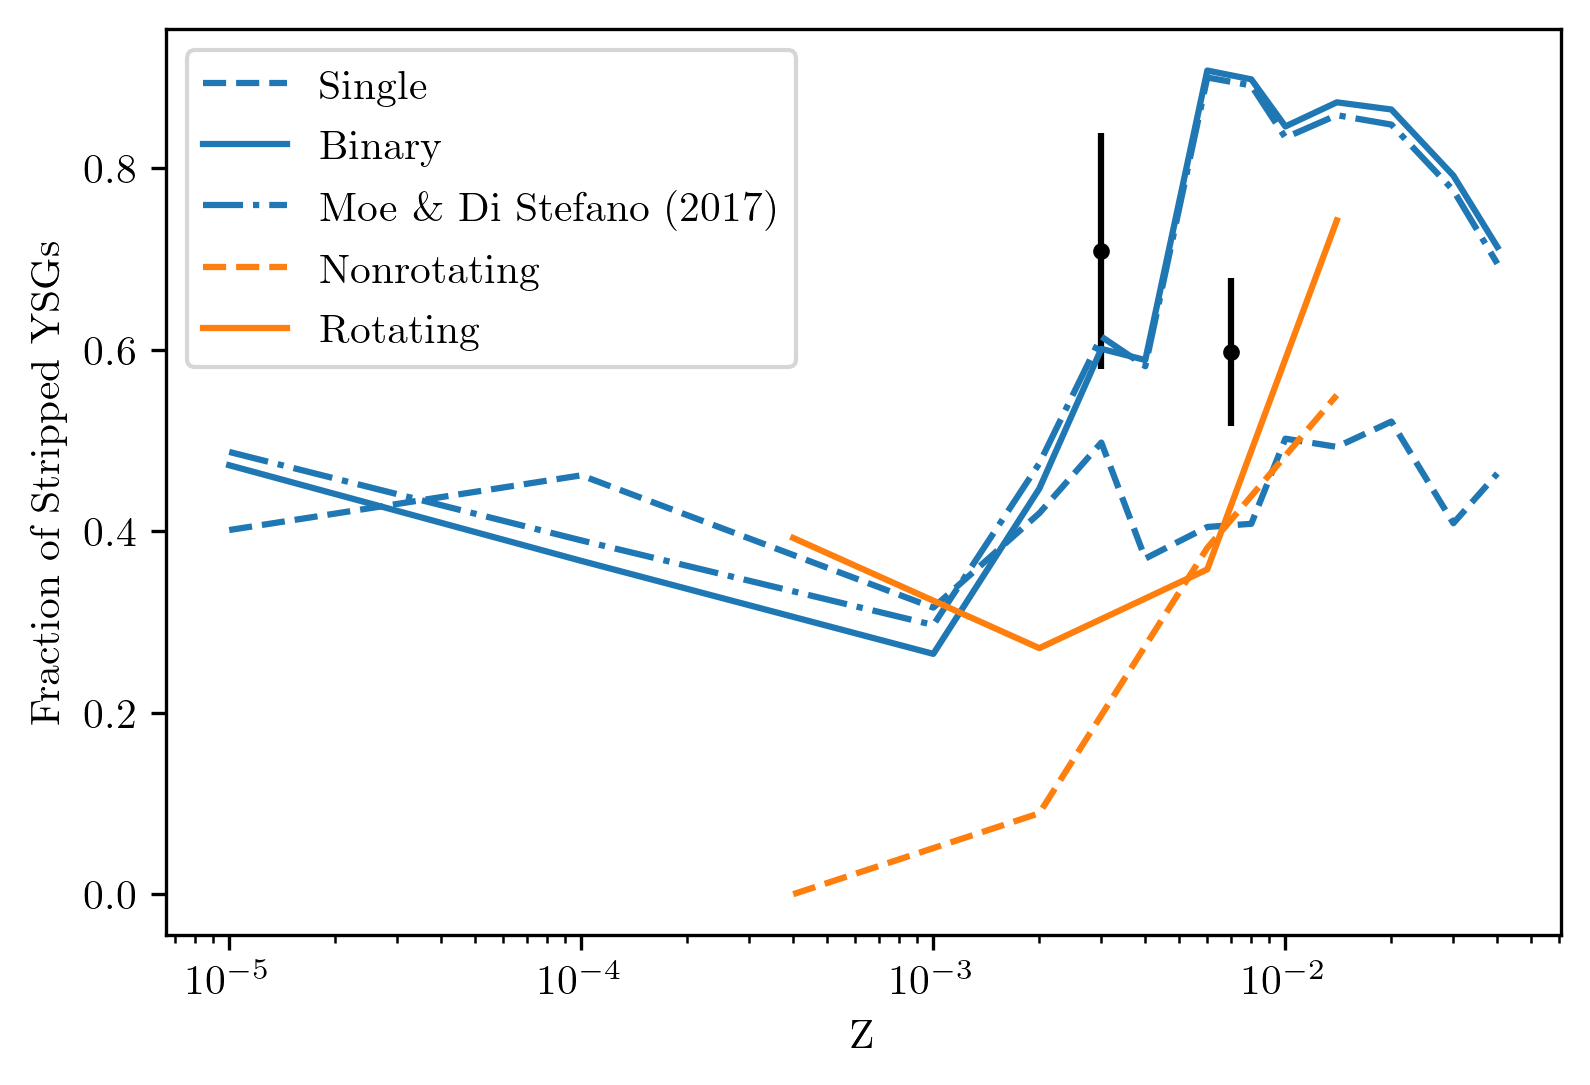

In [16]:
ls_dict = {0.0:'--',1.0:'-'}

fM = 1.0

fig = plt.figure(dpi=300)
f_bins = [0.0,1.0]
f_rots = [0.0,1.0]
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.003,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
znames=['zem5','zem4','z001','z002','z003','z004','z006','z008','z010','z014','z020','z030','z040']
for f_bin,l in zip(f_bins,bin_lab):
    plt.loglog(z_float,[get_ratio_at_parameter('LM_g4/In',z,np.log10(13.7e9),f_bin=f_bin,SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames],c='C0',ls=ls_dict[f_bin],label=l)
plt.loglog(z_float,[get_ratio_at_parameter('LM_g4/In',z,np.log10(13.7e9),f_bin=1.0,crit='moe',SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames],c='C0',ls='-.',label='Moe \& Di Stefano (2017)')


z_float_g = [0.0004,0.002,0.006,0.014]
znames_g=['z0004','z002','z006','z014']
for f_rot,l in zip(f_rots,rot_lab):
    plt.loglog(z_float_g,[get_ratio_at_parameter('LM_g4/In',z,np.log10(13.7e9),f_rot=f_rot,SFH='const',fMcut1=fM,fMcut2=1.0) for z in znames_g],c='C1',ls=ls_dict[f_rot],label=l)
  
mets = [0.003,0.007]
plt.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
plt.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)
plt.yscale('linear')

plt.xlabel('Z')
plt.ylabel('Fraction of Stripped YSGs')

plt.legend(loc='upper left')

plt.savefig('../plots/stripped_LM4.pdf')

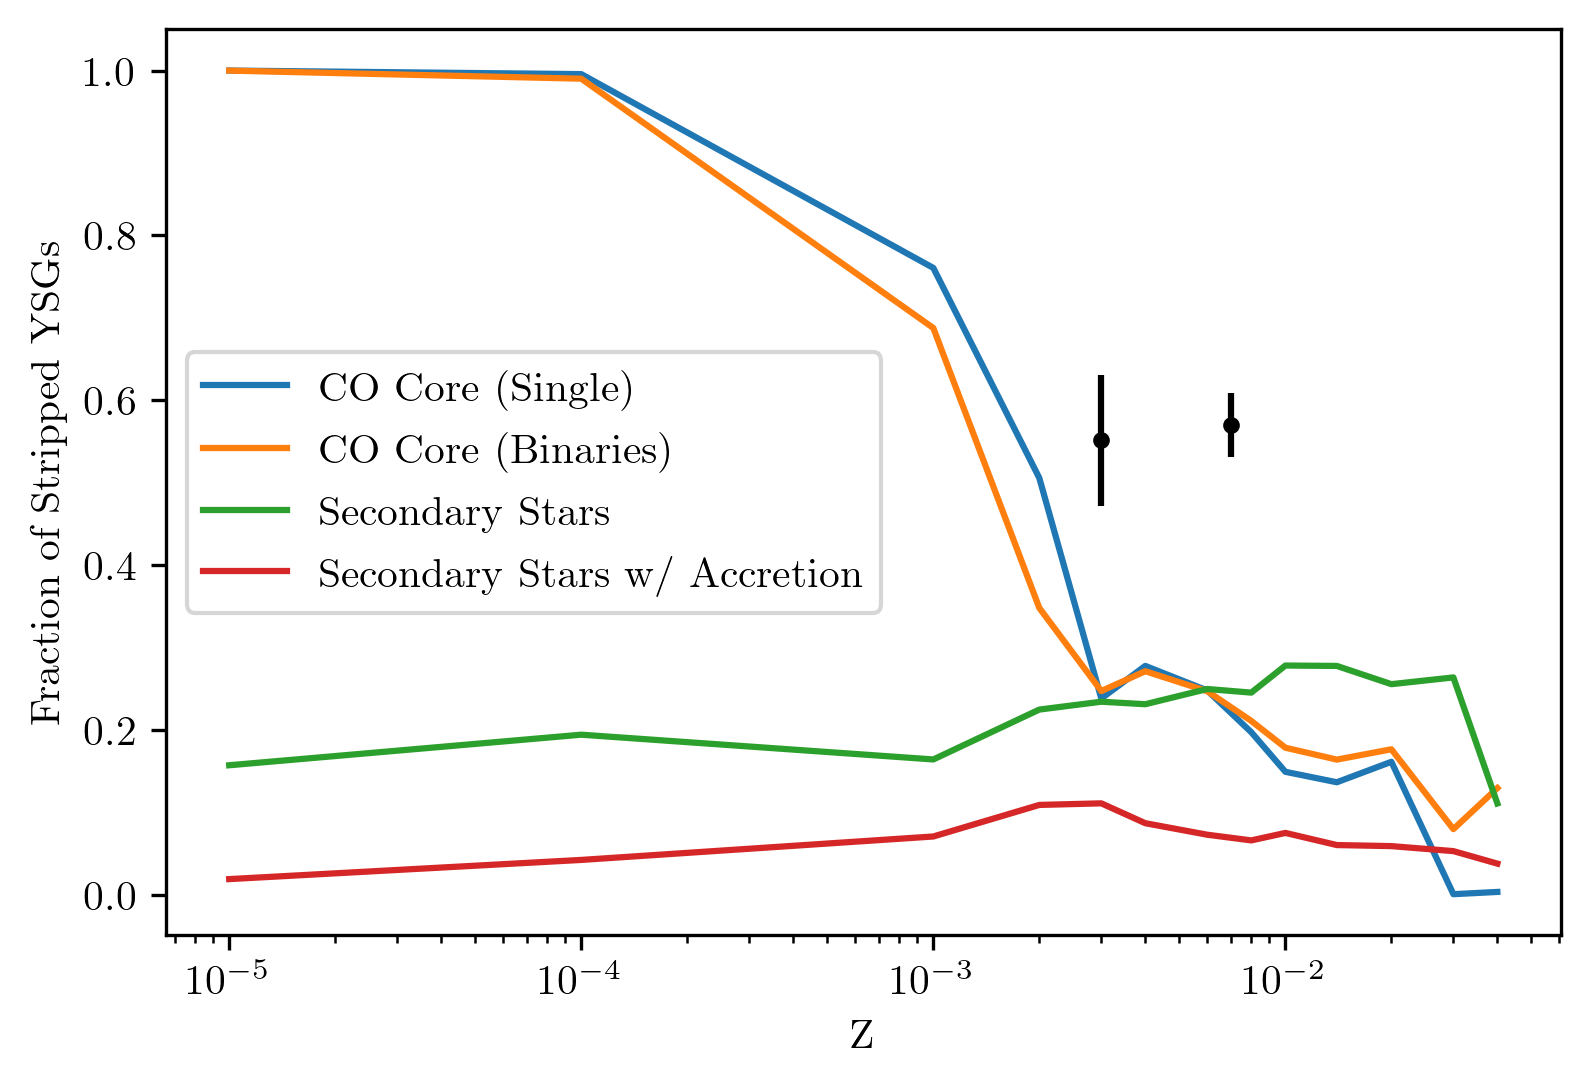

In [8]:
#Alternatively...
singles_jan = pd.read_csv('ncounts/singles_jan.txt',sep='\s+',names=('Metallicity','_','Numberxdt','Frac.CO','Frac.Sec_Accrete','Frac.Sec'))
binaries_jan = pd.read_csv('ncounts/binaries_jan.txt',sep='\s+',names=('Metallicity','_','Numberxdt','Frac.CO','Frac.Sec_Accrete','Frac.Sec'))

fig = plt.figure(dpi=300)

plt.semilogx(z_float,singles_jan['Frac.CO'],label='CO Core (Single)')
plt.semilogx(z_float,binaries_jan['Frac.CO'],label='CO Core (Binaries)')
plt.semilogx(z_float,binaries_jan['Frac.Sec'],label='Secondary Stars')
plt.semilogx(z_float,binaries_jan['Frac.Sec_Accrete'],label='Secondary Stars w/ Accretion')

mets = [0.003,0.007]
plt.errorbar(mets[0],smc_conf[0],yerr=smc_conf[1],fmt='o',c='k',markersize=3)
plt.errorbar(mets[1],lmc_conf[0],yerr=lmc_conf[1],fmt='o',c='k',markersize=3)


plt.xlabel('Z')
plt.ylabel('Fraction of Stripped YSGs')

plt.legend(loc='center left')

plt.savefig('stripped_BPASS.pdf')

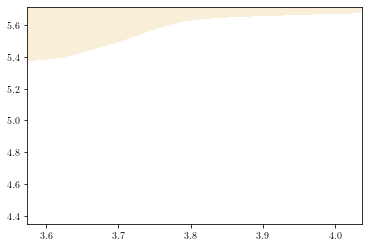

In [31]:
plt.contourf(X,Y,Z_pulse/Z_all,levels=[1.6,1e10],colors='wheat',alpha=0.5)
